In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
!pip install nltk wordcloud sentence-transformers
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
!pip uninstall numpy spacy -y

Found existing installation: numpy 2.2.5
Uninstalling numpy-2.2.5:
  Successfully uninstalled numpy-2.2.5
Found existing installation: spacy 3.5.3
Uninstalling spacy-3.5.3:
  Successfully uninstalled spacy-3.5.3


In [28]:
!pip install spacy

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 54.3 MB/s eta 0:00:00
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.6/443.6 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 49.7 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.22
    Uninstalling pydantic-1.10.22:
      Successfully uninstalled pydantic-1.10.22
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.12
    Uninstalling t

In [22]:
!python -m spacy download en_core_web_sm

2025-04-28 01:47:20.586874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745804840.856142    1933 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745804840.929023    1933 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 01:47:21.465959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 01:47:28.110154: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

In [83]:
import pandas as pd

# Load training data
stances = pd.read_csv('train_stances.csv')
bodies = pd.read_csv('train_bodies.csv')

# Merge on Body ID
df = pd.merge(stances, bodies, how='left', on='Body ID')
print(df.shape)
df.head()


(49972, 4)


,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [84]:
print("Original Shape:", df.shape)
print("\nDuplicate entries:", df.duplicated().sum())
# Remove duplicates
df = df.drop_duplicates()
# Check shape after cleaning
print("Shape after Removing Duplicates:", df.shape)

# Check for missing values
print("Missing values:\n", df.isnull().sum())
df.head()

Original Shape: (49972, 4)

Duplicate entries: 402
Shape after Removing Duplicates: (49570, 4)
Missing values:
 Headline       0
Body ID        0
Stance         0
articleBody    0
dtype: int64


,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [85]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text) # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = text.strip()
    text = re.sub('\s+', ' ', text) # remove extra spaces
    return text


In [86]:
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)


In [87]:
def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)


In [88]:
def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text


In [89]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [90]:
df['clean_headline'] = df['Headline'].astype(str).apply(preprocess_text)
df['clean_body'] = df['articleBody'].astype(str).apply(preprocess_text)

df[['Headline', 'clean_headline', 'articleBody', 'clean_body']].head()


,Headline,clean_headline,articleBody,clean_body
0,Police find mass graves with at least '15 bodi...,police find mass graf least body near mexico t...,Danny Boyle is directing the untitled film\n\n...,danny boyle directing untitled film seth rogen...
1,Hundreds of Palestinians flee floods in Gaza a...,hundred palestinian flee flood gaza israel ope...,Hundreds of Palestinians were evacuated from t...,hundred palestinian evacuated home sunday morn...
2,"Christian Bale passes on role of Steve Jobs, a...",christian bale pass role steve job actor repor...,30-year-old Moscow resident was hospitalized w...,yearold moscow resident hospitalized wound int...
3,HBO and Apple in Talks for $15/Month Apple TV ...,hbo apple talk month apple tv streaming servic...,(Reuters) - A Canadian soldier was shot at the...,reuters canadian soldier shot canadian war mem...
4,Spider burrowed through tourist's stomach and ...,spider burrowed tourist stomach chest,"Fear not arachnophobes, the story of Bunbury's...",fear arachnophobes story bunburys spiderman mi...


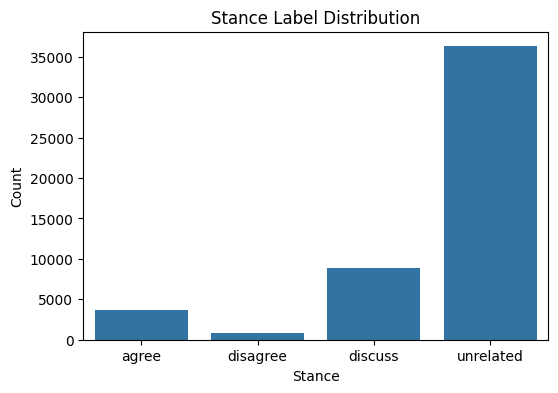

In [91]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Stance', order=['agree', 'disagree', 'discuss', 'unrelated'])
plt.title("Stance Label Distribution")
plt.xlabel("Stance")
plt.ylabel("Count")
plt.show()


In [92]:
df['headline_word_count'] = df['Headline'].apply(lambda x: len(str(x).split()))
df['body_word_count'] = df['articleBody'].apply(lambda x: len(str(x).split()))
df['headline_char_count'] = df['Headline'].apply(lambda x: len(str(x)))
df['body_char_count'] = df['articleBody'].apply(lambda x: len(str(x)))


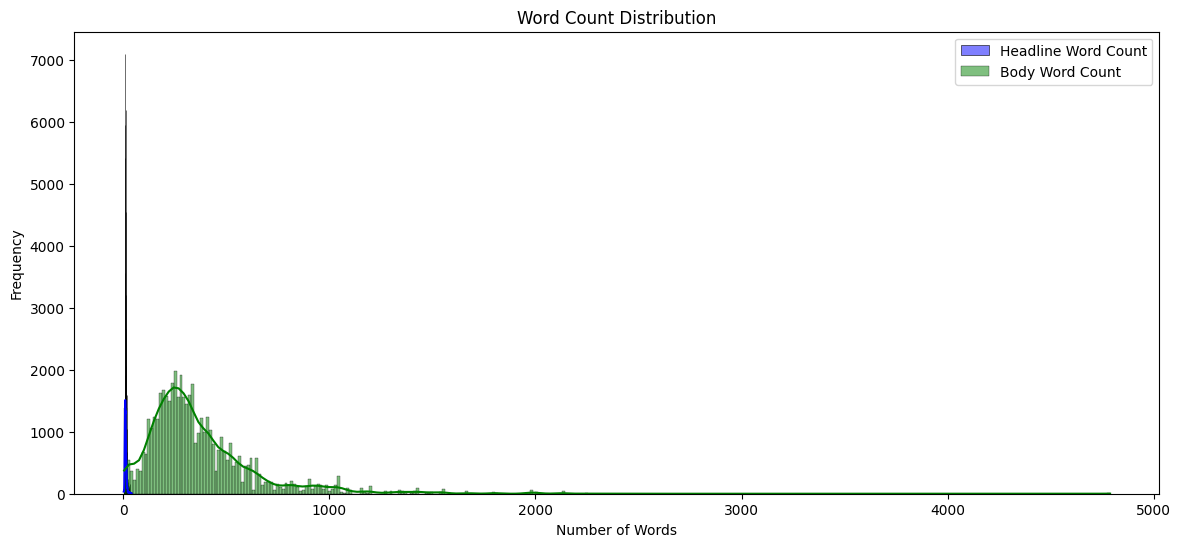

In [93]:
plt.figure(figsize=(14,6))
sns.histplot(df['headline_word_count'], color='blue', kde=True, label='Headline Word Count')
sns.histplot(df['body_word_count'], color='green', kde=True, label='Body Word Count')
plt.legend()
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


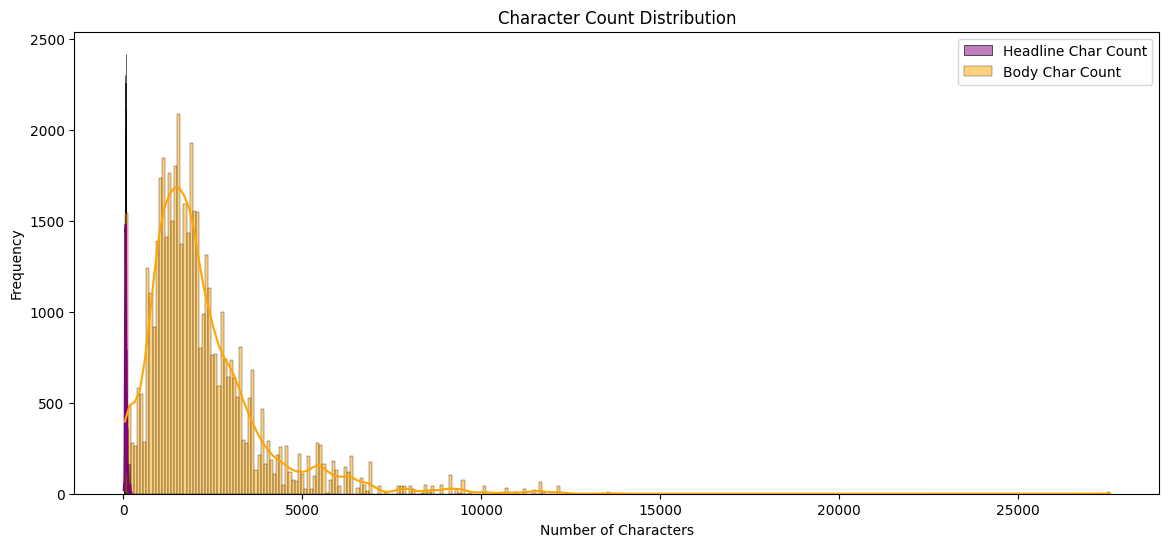

In [94]:
plt.figure(figsize=(14,6))
sns.histplot(df['headline_char_count'], color='purple', kde=True, label='Headline Char Count')
sns.histplot(df['body_char_count'], color='orange', kde=True, label='Body Char Count')
plt.legend()
plt.title('Character Count Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


In [95]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_headline'] + " " + df['clean_body'])
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (49570, 5000)


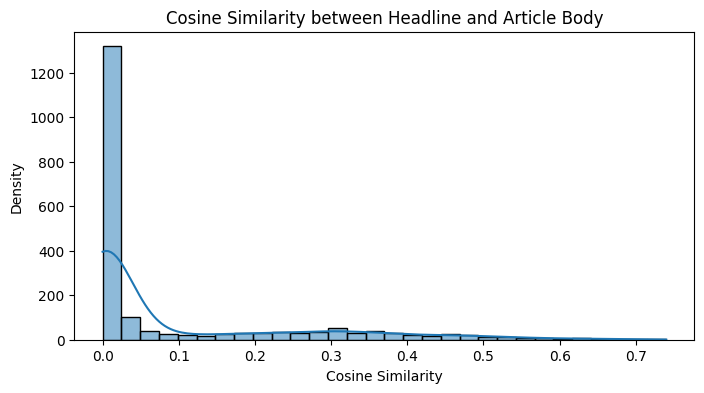

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sample 2000 rows for speed
sample_df = df.sample(2000, random_state=42)

# Vectorize using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(sample_df['Headline'] + " " + sample_df['articleBody'])

# Compute similarity for each pair
similarities = []
for i in range(len(sample_df)):
    headline_vec = tfidf.transform([sample_df.iloc[i]['Headline']])
    body_vec = tfidf.transform([sample_df.iloc[i]['articleBody']])
    sim = cosine_similarity(headline_vec, body_vec)[0][0]
    similarities.append(sim)

sample_df['similarity'] = similarities

# Plot similarity
plt.figure(figsize=(8,4))
sns.histplot(sample_df['similarity'], bins=30, kde=True)
plt.title("Cosine Similarity between Headline and Article Body")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.show()


In [97]:
def ngram_overlap(text1, text2, n=2):
    tokens1 = nltk.ngrams(text1.split(), n)
    tokens2 = nltk.ngrams(text2.split(), n)
    tokens1 = set(tokens1)
    tokens2 = set(tokens2)
    if len(tokens1.union(tokens2)) == 0:
        return 0
    return len(tokens1.intersection(tokens2)) / len(tokens1.union(tokens2))

df['bigram_overlap'] = df.apply(lambda row: ngram_overlap(row['clean_headline'], row['clean_body']), axis=1)

In [98]:
def word_overlap(text1, text2):
    set1 = set(text1.split())
    set2 = set(text2.split())
    if len(set1.union(set2)) == 0:
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

df['word_overlap'] = df.apply(lambda row: word_overlap(row['clean_headline'], row['clean_body']), axis=1)


In [99]:
refuting_words = ["fake", "fraud", "hoax", "false", "deny", "denies", "refute", "not", "despite", "nope", "doubt", "bogus", "debunk", "pranks"]

def count_refuting_words(text):
    words = text.split()
    return sum([1 for w in words if w in refuting_words])

df['refuting_words_count'] = df['clean_headline'].apply(count_refuting_words)


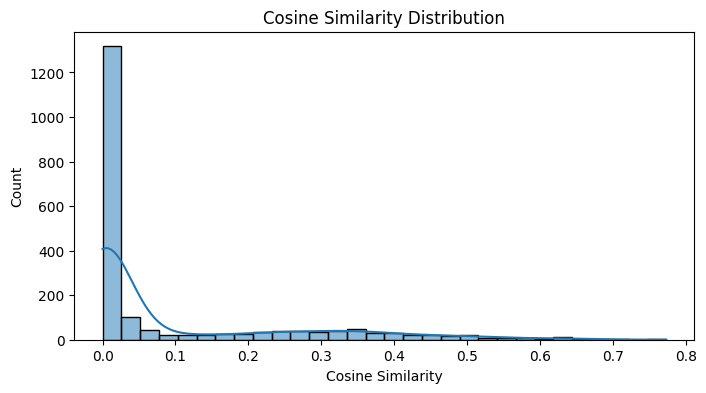

In [100]:
sample_df = df.sample(2000, random_state=42)

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix_sample = tfidf.fit_transform(sample_df['clean_headline'] + " " + sample_df['clean_body'])

similarities = []
for i in range(len(sample_df)):
    headline_vec = tfidf.transform([sample_df.iloc[i]['clean_headline']])
    body_vec = tfidf.transform([sample_df.iloc[i]['clean_body']])
    sim = cosine_similarity(headline_vec, body_vec)[0][0]
    similarities.append(sim)

sample_df['cosine_similarity'] = similarities

plt.figure(figsize=(8,4))
sns.histplot(sample_df['cosine_similarity'], bins=30, kde=True)
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.show()


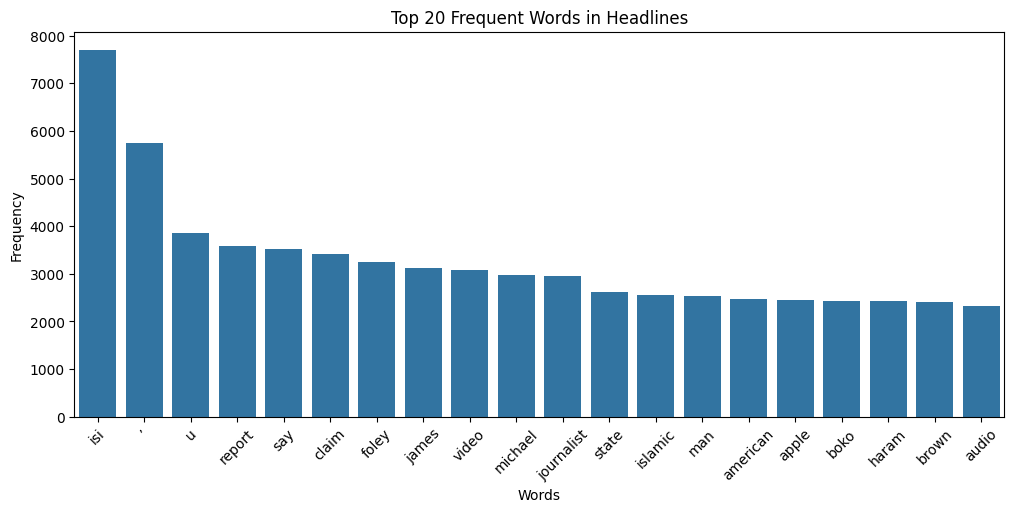

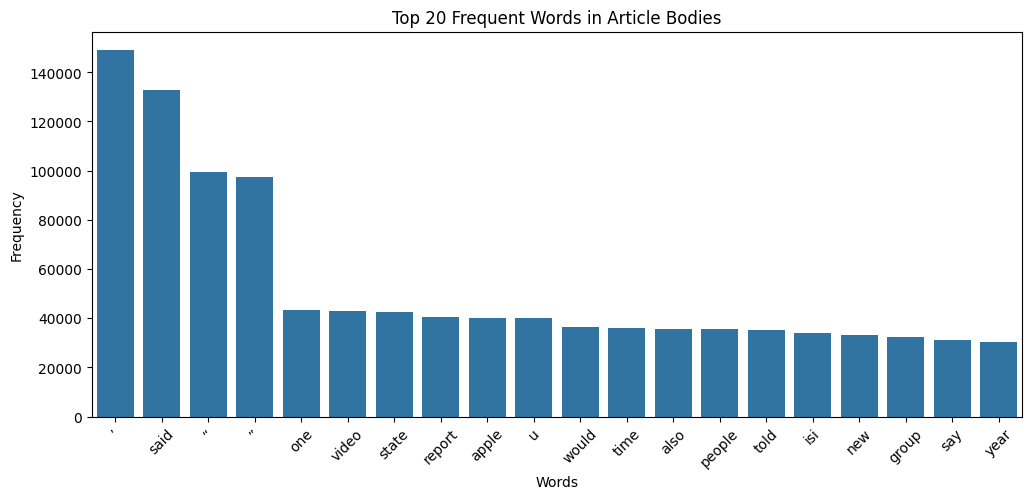

In [101]:
def plot_top_words(text_data, title):
    all_words = ' '.join(text_data).split()
    freq_dist = nltk.FreqDist(all_words)
    common_words = freq_dist.most_common(20)
    words, counts = zip(*common_words)

    plt.figure(figsize=(12,5))
    sns.barplot(x=list(words), y=list(counts))
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    plt.show()

plot_top_words(df['clean_headline'], 'Top 20 Frequent Words in Headlines')
plot_top_words(df['clean_body'], 'Top 20 Frequent Words in Article Bodies')


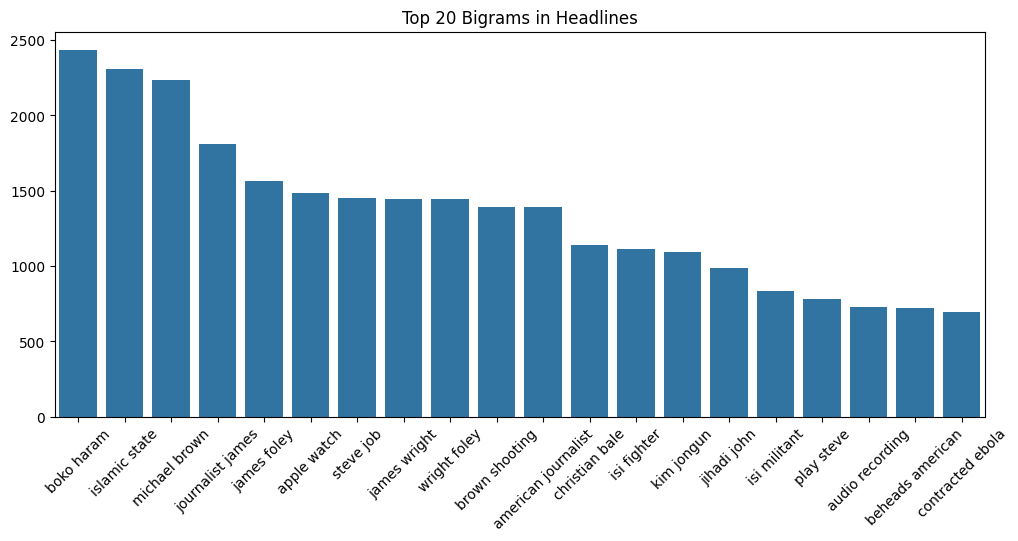

In [102]:
def get_top_ngrams(texts, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    bag_of_words = vec.fit_transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top_bigrams = get_top_ngrams(df['clean_headline'], ngram_range=(2,2))
bigrams, counts = zip(*top_bigrams)

plt.figure(figsize=(12,5))
sns.barplot(x=list(bigrams), y=list(counts))
plt.title('Top 20 Bigrams in Headlines')
plt.xticks(rotation=45)
plt.show()


In [103]:
# Step 2.1:Word Embeddings (GloVe) Cosine Similarity

import numpy as np

# Load GloVe word embeddings
def load_glove_embeddings(glove_file_path):
    embeddings = {}
    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Load GloVe (path needs to be correct!)
glove_embeddings = load_glove_embeddings('glove.6B.300d.txt')

print(f"Loaded {len(glove_embeddings)} word vectors from GloVe.")


Loaded 400000 word vectors from GloVe.


In [104]:
# Function to average GloVe embeddings for a text
def get_average_embedding(text, embeddings, dim=300):
    words = text.split()
    vectors = []
    for word in words:
        if word in embeddings:
            vectors.append(embeddings[word])
    if len(vectors) == 0:
        return np.zeros(dim)
    else:
        return np.mean(vectors, axis=0)


In [105]:
# Get GloVe embeddings for headline and body
headline_glove_embeddings = []
body_glove_embeddings = []

for i in range(len(df)):
    headline_emb = get_average_embedding(df.iloc[i]['clean_headline'], glove_embeddings)
    body_emb = get_average_embedding(df.iloc[i]['clean_body'], glove_embeddings)

    headline_glove_embeddings.append(headline_emb)
    body_glove_embeddings.append(body_emb)

df['headline_glove_emb'] = headline_glove_embeddings
df['body_glove_emb'] = body_glove_embeddings


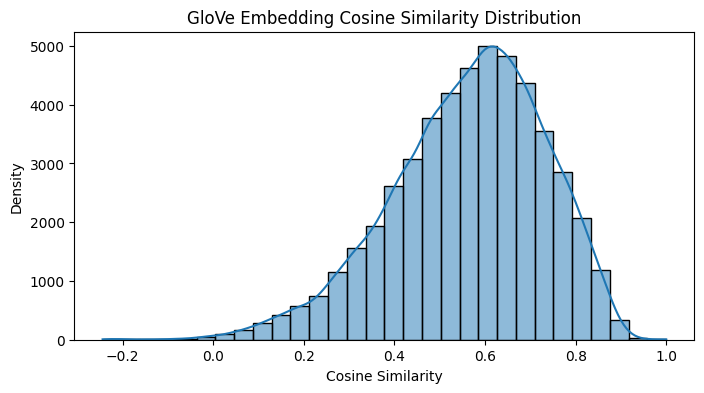

In [106]:
# Calculate cosine similarity between GloVe embeddings
from sklearn.metrics.pairwise import cosine_similarity

glove_similarities = []
for i in range(len(df)):
    sim = cosine_similarity([df.iloc[i]['headline_glove_emb']], [df.iloc[i]['body_glove_emb']])[0][0]
    glove_similarities.append(sim)

df['glove_cosine_similarity'] = glove_similarities

# Plot distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df['glove_cosine_similarity'], bins=30, kde=True)
plt.title('GloVe Embedding Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.show()


In [107]:
# Combine Headline and Body GloVe Embeddings

import numpy as np

# 1. Concatenation
concat_embeddings = []
for i in range(len(df)):
    concat = np.concatenate((df.iloc[i]['headline_glove_emb'], df.iloc[i]['body_glove_emb']))
    concat_embeddings.append(concat)
df['concat_glove_emb'] = concat_embeddings

# 2. Absolute Difference
abs_diff_embeddings = []
for i in range(len(df)):
    diff = np.abs(df.iloc[i]['headline_glove_emb'] - df.iloc[i]['body_glove_emb'])
    abs_diff_embeddings.append(diff)
df['absdiff_glove_emb'] = abs_diff_embeddings

print("Created combined embedding features: 'concat_glove_emb' and 'absdiff_glove_emb'")


Created combined embedding features: 'concat_glove_emb' and 'absdiff_glove_emb'


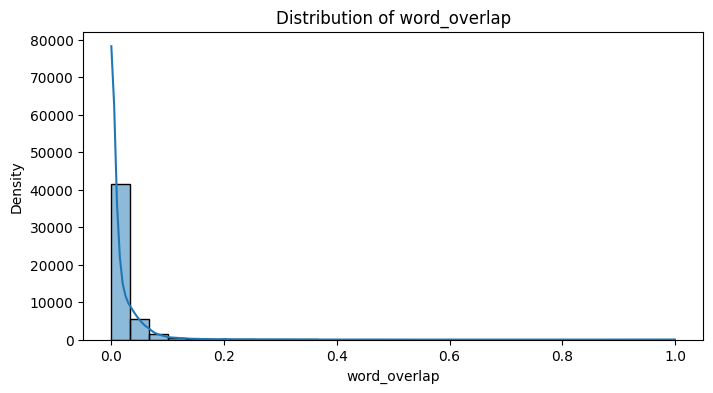

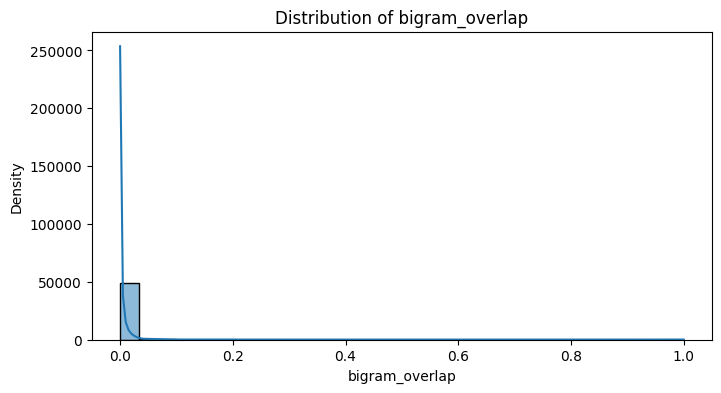

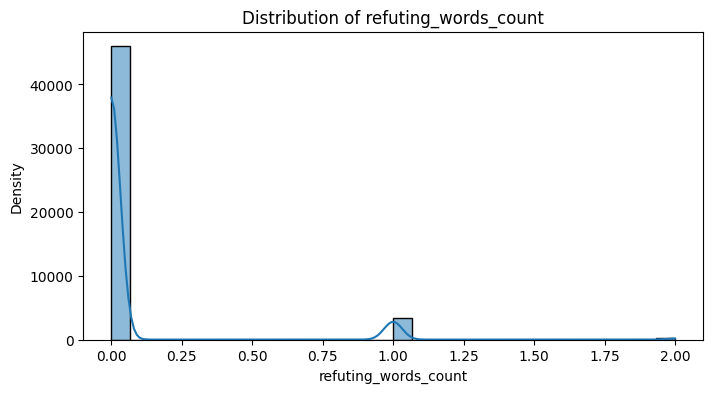

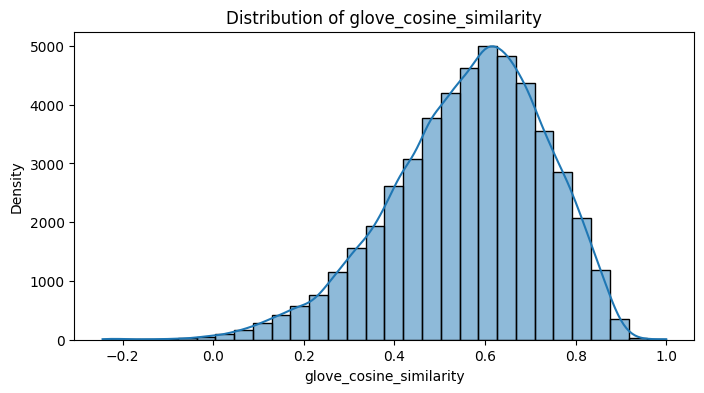

In [108]:
# Feature Importance Insights
import seaborn as sns
import matplotlib.pyplot as plt

# Only existing features
feature_cols = ['word_overlap', 'bigram_overlap',
                'refuting_words_count',
                'glove_cosine_similarity']

# Plot each feature distribution
for feature in feature_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()


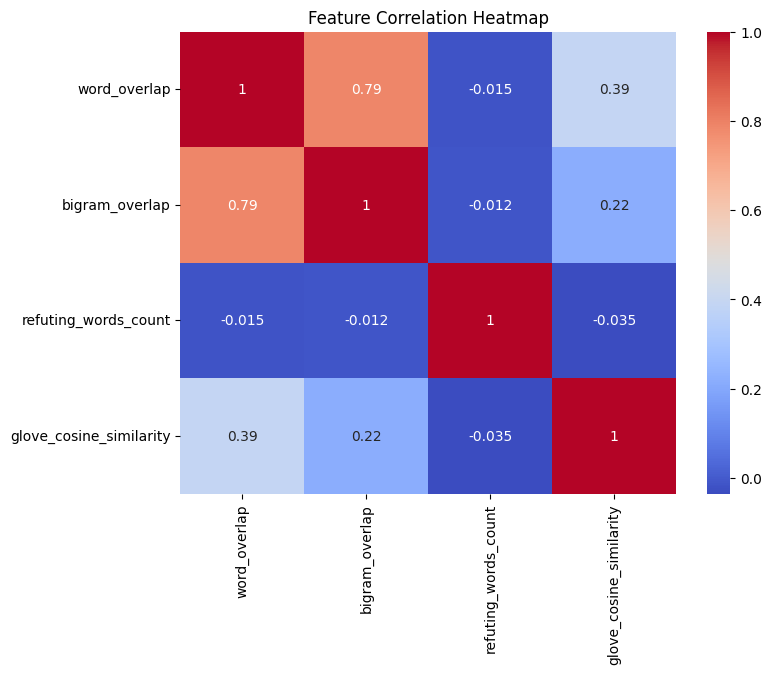

In [109]:
# Optional: Feature Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

corr_features = df[['word_overlap', 'bigram_overlap',
                    'refuting_words_count',
                    'glove_cosine_similarity']]

plt.figure(figsize=(8,6))
sns.heatmap(corr_features.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


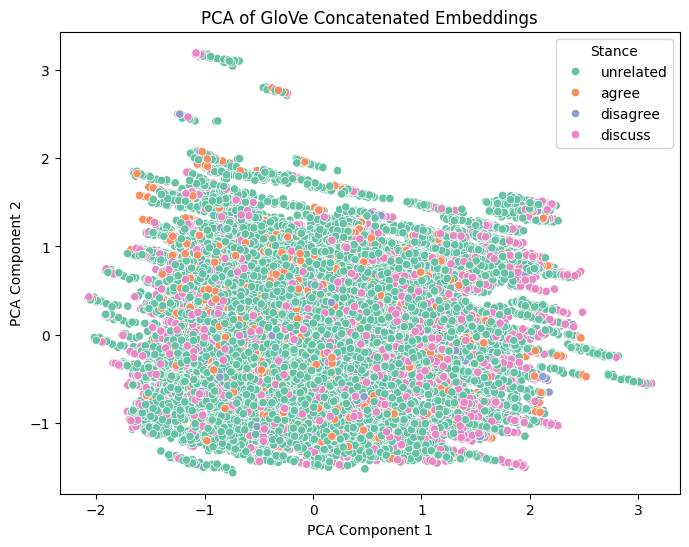

In [110]:
# Optional: PCA Visualization for GloVe embeddings
from sklearn.decomposition import PCA

# Reduce concatenated glove embeddings to 2D
pca = PCA(n_components=2)
glove_pca = pca.fit_transform(list(df['concat_glove_emb']))

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=glove_pca[:,0], y=glove_pca[:,1], hue=df['Stance'], palette='Set2')
plt.title('PCA of GloVe Concatenated Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


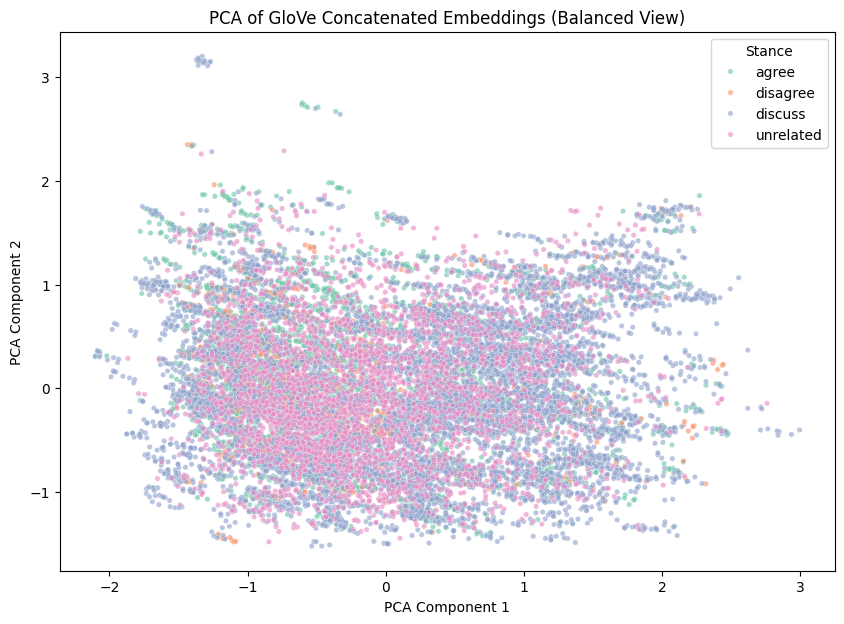

In [111]:
# Improved PCA Visualization

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Optional: Subsample unrelated examples
df_sampled = pd.concat([
    df[df['Stance'] == 'agree'],
    df[df['Stance'] == 'disagree'],
    df[df['Stance'] == 'discuss'],
    df[df['Stance'] == 'unrelated'].sample(3000, random_state=42)  # Take only 3000 unrelated
])

# PCA
pca = PCA(n_components=2)
glove_pca = pca.fit_transform(list(df_sampled['concat_glove_emb']))

# Plot
plt.figure(figsize=(10,7))
sns.scatterplot(x=glove_pca[:,0], y=glove_pca[:,1],
                hue=df_sampled['Stance'],
                palette='Set2',
                alpha=0.6,   # Make points transparent
                s=15)        # Make points smaller
plt.title('PCA of GloVe Concatenated Embeddings (Balanced View)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Stance', fontsize=10)
plt.show()


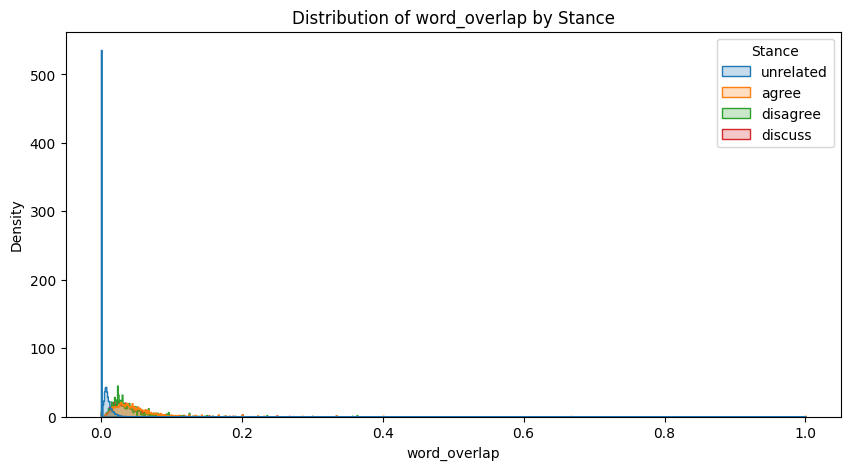

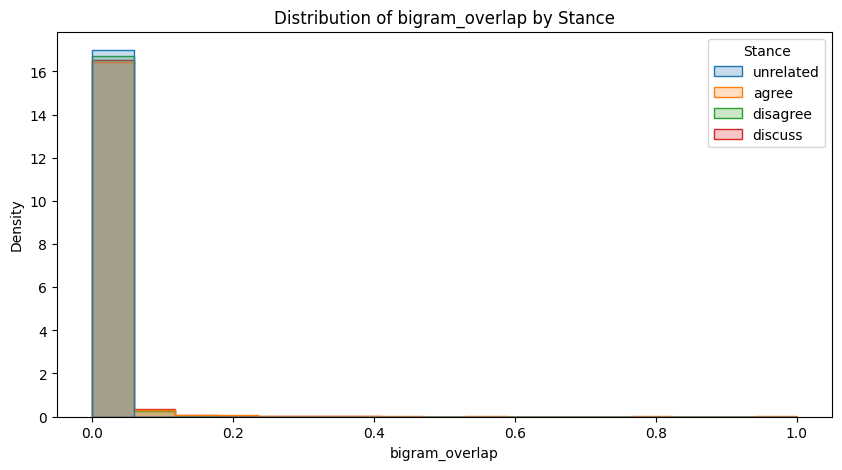

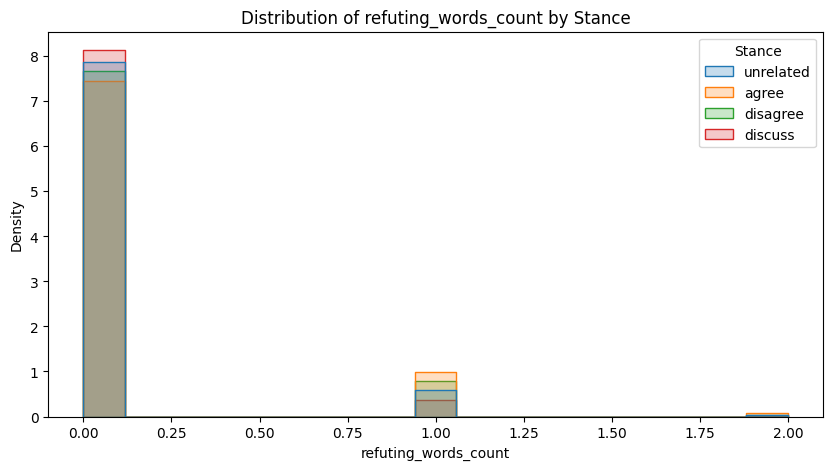

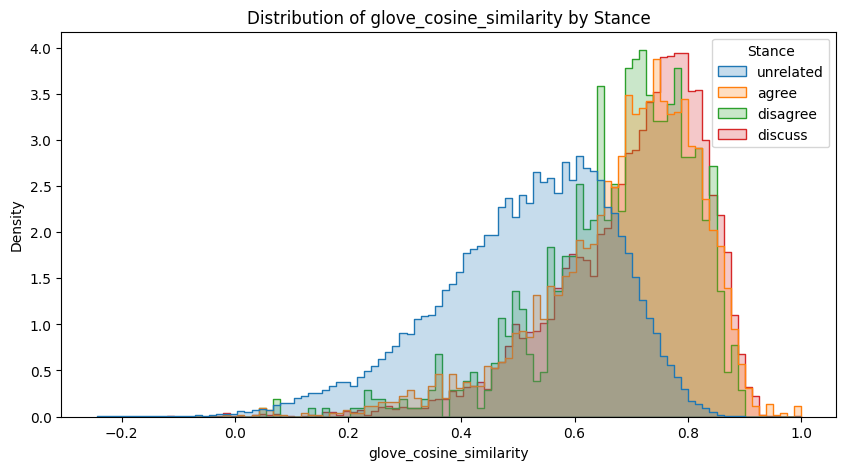

In [112]:
# Class-wise Distribution of Important Features
important_features = ['word_overlap', 'bigram_overlap',
                      'refuting_words_count',
                      'glove_cosine_similarity']

for feature in important_features:
    plt.figure(figsize=(10,5))
    sns.histplot(data=df, x=feature, hue='Stance', element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} by Stance')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()


In [113]:
# Mean feature values grouped by stance
mean_feature_by_class = df.groupby('Stance')[important_features].mean().round(3)
display(mean_feature_by_class)


,word_overlap,bigram_overlap,refuting_words_count,glove_cosine_similarity
Stance,,,,
agree,0.055,0.016,0.135,0.686
disagree,0.043,0.010,0.101,0.678
discuss,0.050,0.012,0.044,0.702
unrelated,0.005,0.000,0.078,0.514


In [114]:
#extra features which can help for modelling
# Adding Length Features

df['headline_len'] = df['clean_headline'].apply(lambda x: len(x.split()))
df['body_len'] = df['clean_body'].apply(lambda x: len(x.split()))
df['len_ratio'] = df['headline_len'] / (df['body_len'] + 1)  # +1 to avoid division by zero

# Quick check
df[['headline_len', 'body_len', 'len_ratio']].head()


,headline_len,body_len,len_ratio
0,13,116,0.111111
1,8,246,0.032389
2,12,96,0.123711
3,10,51,0.192308
4,5,305,0.016340


#Sentiment Analysis

In [115]:
!pip install textblob

In [116]:
from textblob import TextBlob

# Sentiment features
df['headline_polarity'] = df['clean_headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['headline_subjectivity'] = df['clean_headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Quick check
df[['headline_polarity', 'headline_subjectivity']].head()


,headline_polarity,headline_subjectivity
0,-0.100000,0.400000
1,0.000000,0.500000
2,0.142857,0.267857
3,0.000000,0.000000
4,0.000000,0.000000


In [117]:
# Sentiment features for body text
df['body_polarity'] = df['clean_body'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['body_subjectivity'] = df['clean_body'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [118]:
# Sentiment difference (headline vs body)
df['polarity_diff'] = df['headline_polarity'] - df['body_polarity']
df['subjectivity_diff'] = df['headline_subjectivity'] - df['body_subjectivity']


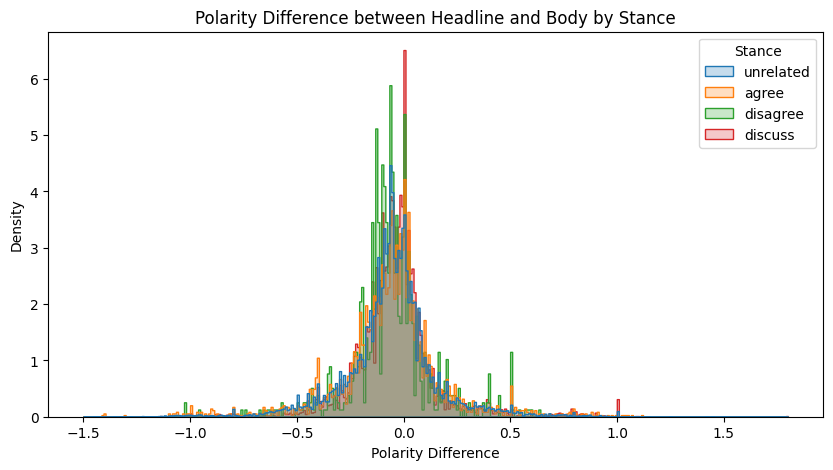

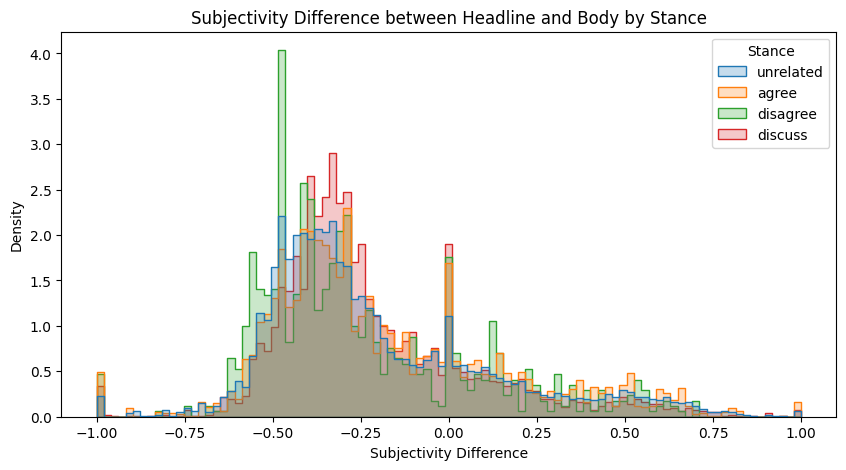

In [119]:
# Plot polarity difference
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='polarity_diff', hue='Stance', element='step', stat='density', common_norm=False)
plt.title('Polarity Difference between Headline and Body by Stance')
plt.xlabel('Polarity Difference')
plt.ylabel('Density')
plt.show()

# Plot subjectivity difference
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='subjectivity_diff', hue='Stance', element='step', stat='density', common_norm=False)
plt.title('Subjectivity Difference between Headline and Body by Stance')
plt.xlabel('Subjectivity Difference')
plt.ylabel('Density')
plt.show()


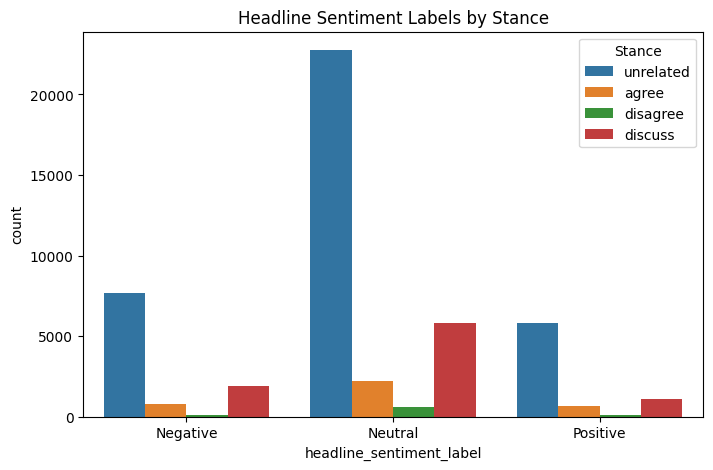

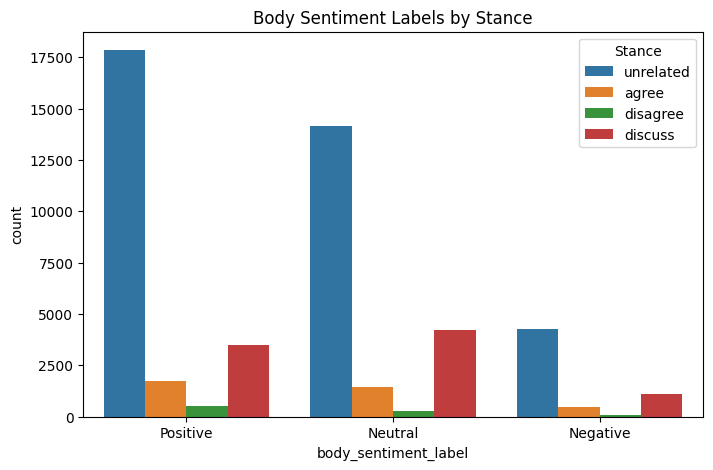

In [120]:
# Categorize polarity into Positive, Negative, Neutral
def sentiment_label(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['headline_sentiment_label'] = df['headline_polarity'].apply(sentiment_label)
df['body_sentiment_label'] = df['body_polarity'].apply(sentiment_label)

# Now you can plot counts!
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='headline_sentiment_label', hue='Stance')
plt.title('Headline Sentiment Labels by Stance')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='body_sentiment_label', hue='Stance')
plt.title('Body Sentiment Labels by Stance')
plt.show()


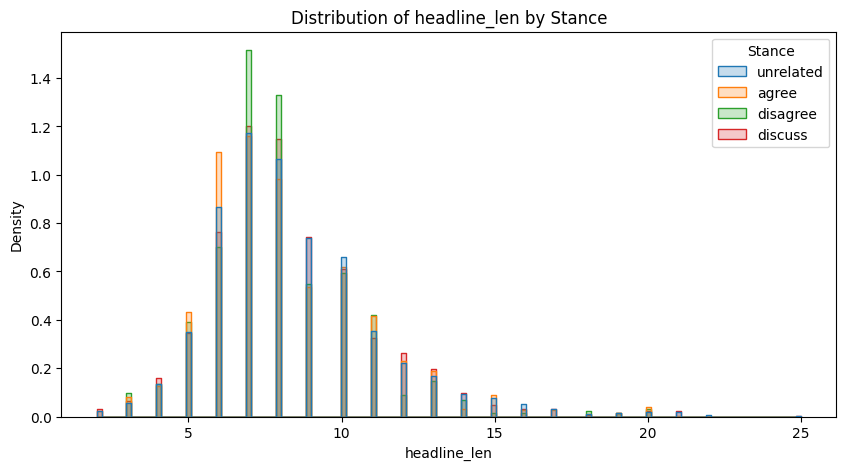

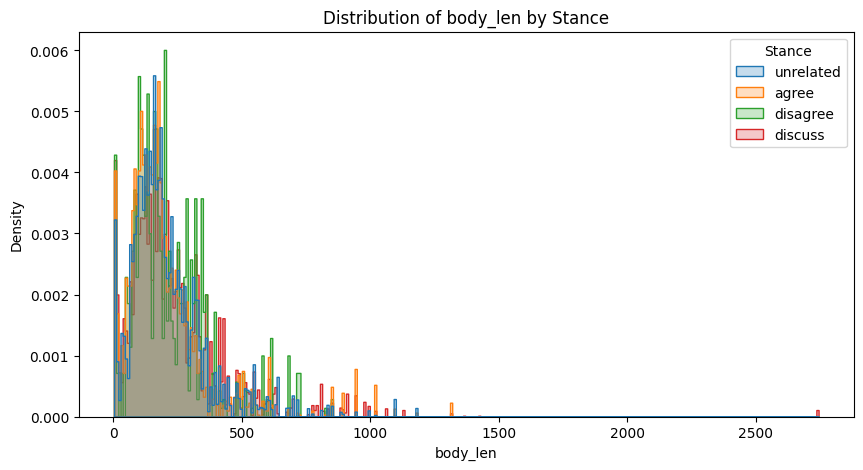

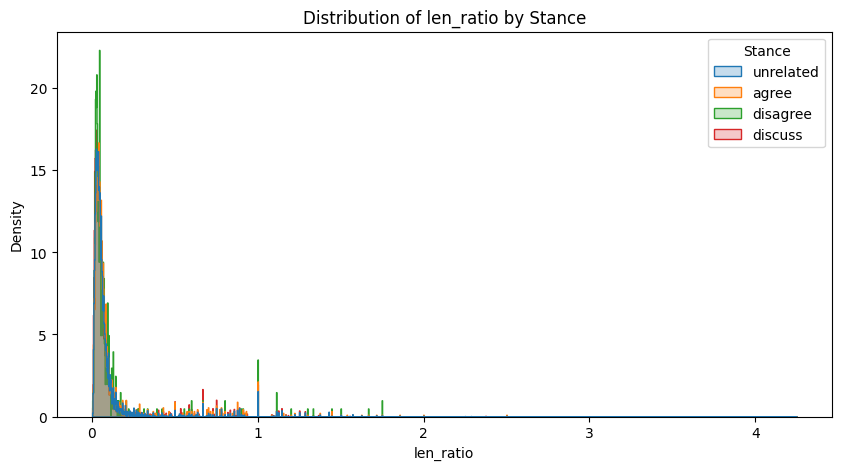

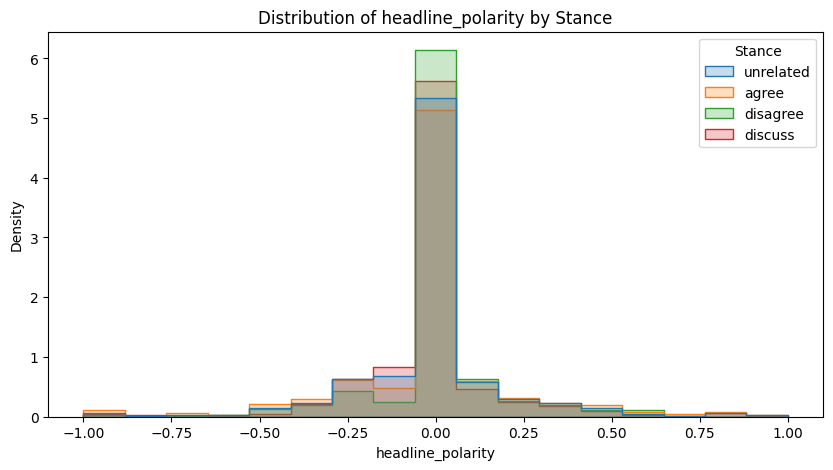

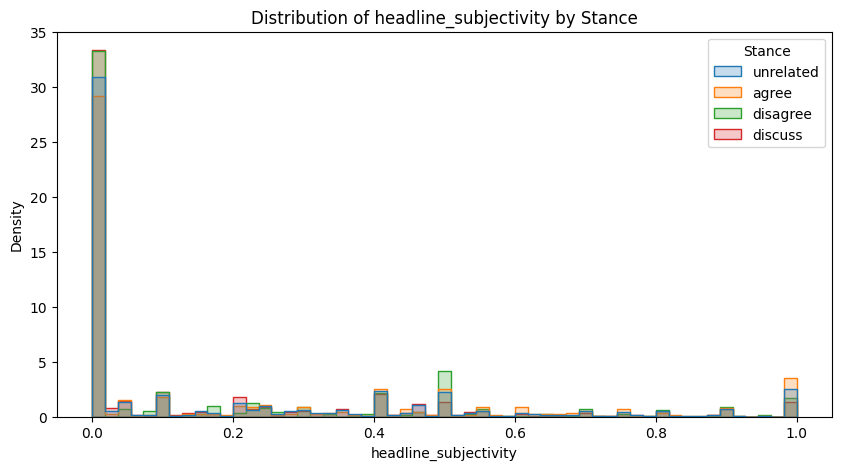

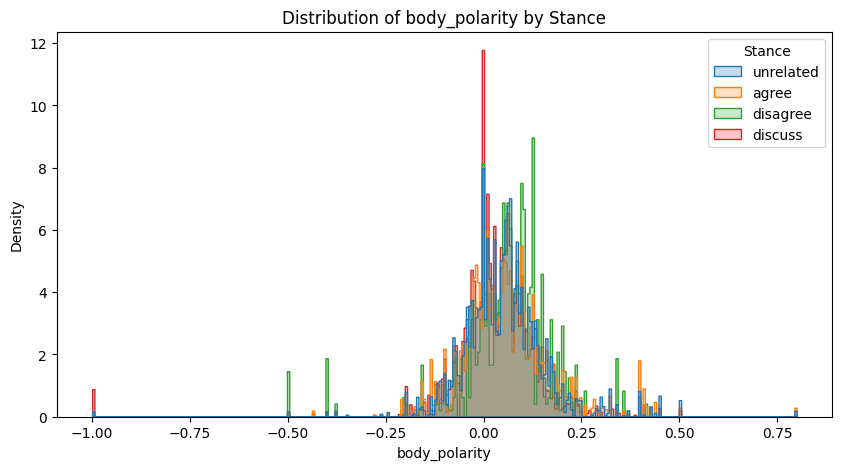

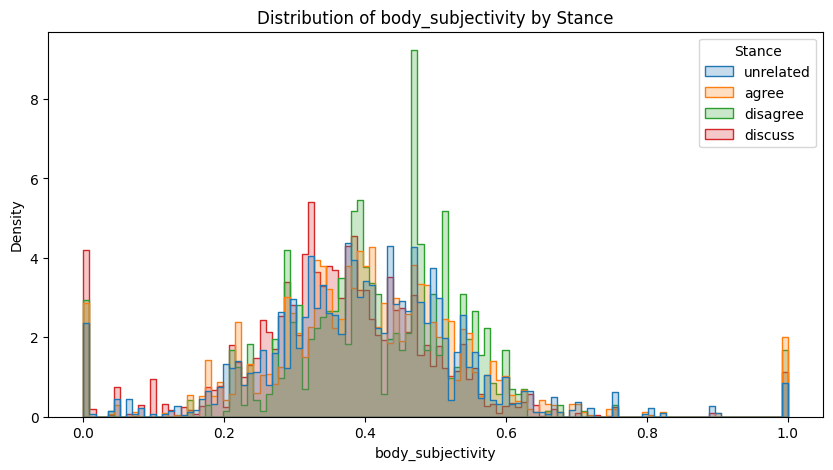

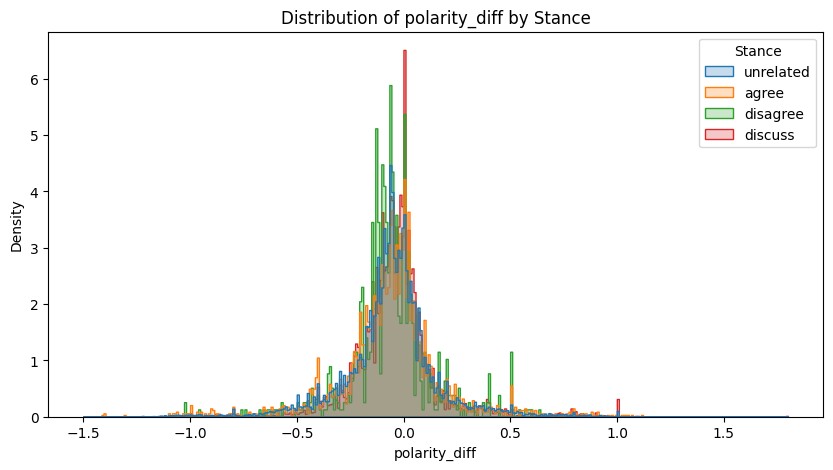

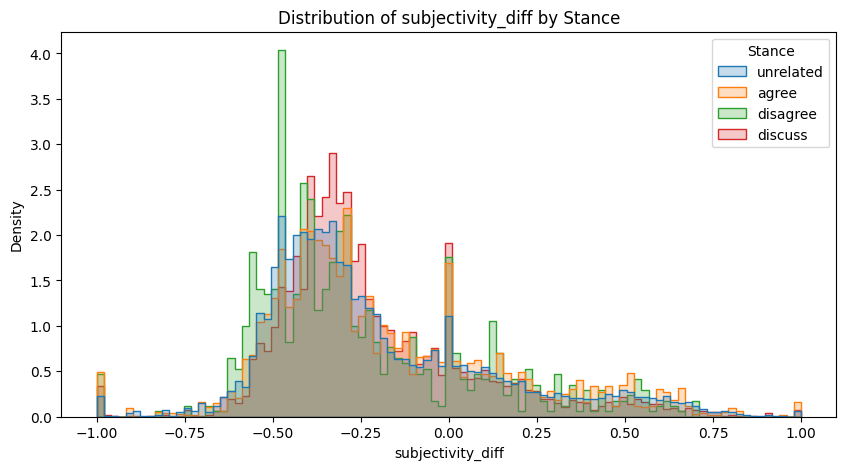

In [121]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# New features to plot
new_features = ['headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']

# Plot each feature separately by stance
for feature in new_features:
    plt.figure(figsize=(10,5))
    sns.histplot(data=df, x=feature, hue='Stance', element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} by Stance')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()


# Model Fitting

In [164]:
# cross validation

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define features (X) and target (y)
X = df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']]
y = df['Stance']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
lr_model = LogisticRegression(max_iter=1000, penalty='l2', C=100) # Increased max_iter

# Perform cross-validation
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5)  # 5-fold cross-validation

print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))

# Train the model on the entire training set
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Get probabilities of stance
probabilities = lr_model.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-validation scores: [0.80168936 0.81465137 0.80380784 0.81074266 0.80166436]
Average cross-validation score: 0.8065111161427423
              precision    recall  f1-score   support

       agree       0.47      0.08      0.14       698
    disagree       0.00      0.00      0.00       151
     discuss       0.63      0.56      0.60      1813
   unrelated       0.86      0.97      0.91      7252

    accuracy                           0.82      9914
   macro avg       0.49      0.40      0.41      9914
weighted avg       0.78      0.82      0.78      9914

Accuracy: 0.8153116804518862


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

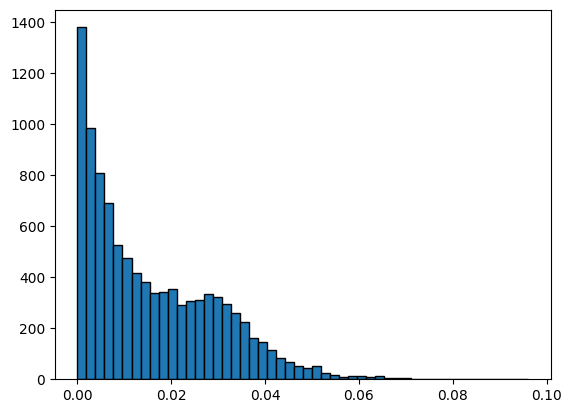

In [165]:
#plot histogram of probabilities
plt.hist(probabilities, bins=50,edgecolor='black')
plt.show()

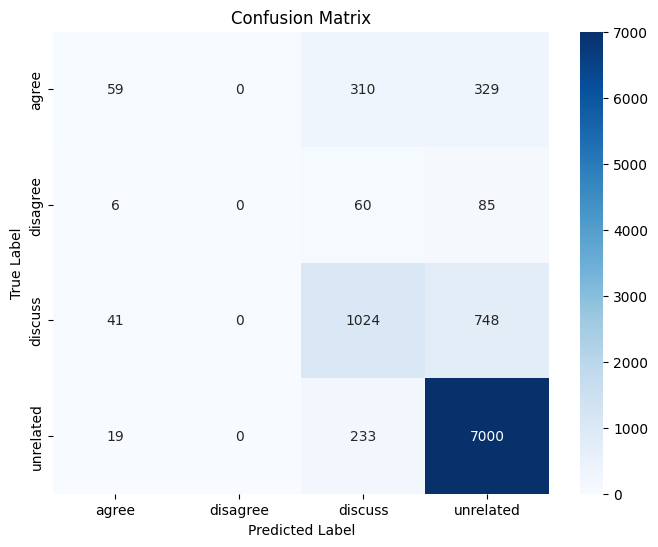

In [166]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have y_test and y_pred from your Logistic Regression model
# ... (your existing code) ...

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


              precision    recall  f1-score   support

       agree       0.68      0.40      0.50       698
    disagree       0.60      0.17      0.26       151
     discuss       0.75      0.88      0.81      1813
   unrelated       0.98      0.99      0.98      7252

    accuracy                           0.91      9914
   macro avg       0.75      0.61      0.64      9914
weighted avg       0.91      0.91      0.91      9914

Accuracy: 0.9141617914060924


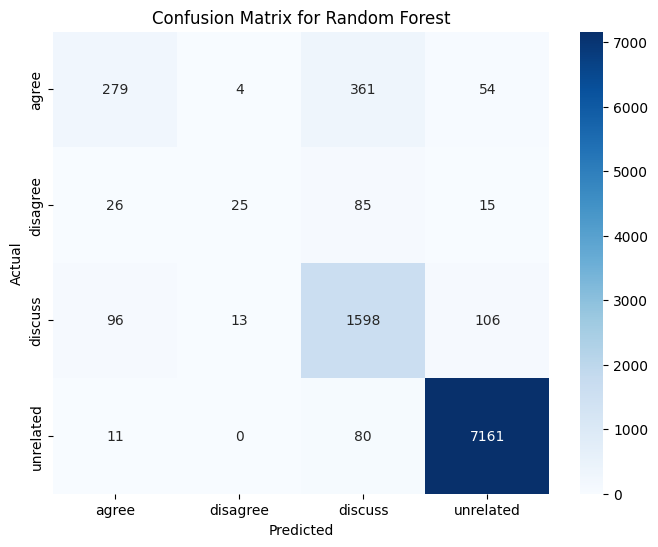

In [167]:
from sklearn.ensemble import RandomForestClassifier

# Define features (X) and target (y)
X = df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']]
y = df['Stance']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)  # You can adjust hyperparameters here

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [168]:
!pip install xgboost

In [169]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Assuming X and y are defined as in your previous code
X = df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']]
y = df['Stance']

# Convert the target variable to numerical labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, objective='multi:softmax', num_class=4) # Specify objective and number of classes

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_)) # Use target_names for label decoding
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


              precision    recall  f1-score   support

       agree       0.71      0.52      0.60       698
    disagree       0.58      0.20      0.30       151
     discuss       0.79      0.88      0.83      1813
   unrelated       0.98      0.99      0.98      7252

    accuracy                           0.92      9914
   macro avg       0.76      0.65      0.68      9914
weighted avg       0.92      0.92      0.92      9914

Accuracy: 0.924349404881985


In [170]:
from sklearn.neighbors import KNeighborsClassifier

X = df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']]
y = df['Stance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=4) # You can adjust the number of neighbors


# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))


              precision    recall  f1-score   support

       agree       0.31      0.19      0.24       698
    disagree       0.20      0.11      0.14       151
     discuss       0.47      0.45      0.46      1813
   unrelated       0.82      0.87      0.84      7252

    accuracy                           0.73      9914
   macro avg       0.45      0.40      0.42      9914
weighted avg       0.71      0.73      0.72      9914

Accuracy: 0.7314908210611257


In [171]:
!pip install lightgbm
import lightgbm as lgb

# Assuming X and y are defined as in your previous code
X = df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']]
y = df['Stance']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the LightGBM classifier
lgb_model = lgb.LGBMClassifier()

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_lgb))
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 39656, number of used features: 13
[LightGBM] [Info] Start training from score -2.599115
[LightGBM] [Info] Start training from score -4.068850
[LightGBM] [Info] Start training from score -1.731764
[LightGBM] [Info] Start training from score -0.312533
              precision    recall  f1-score   support

       agree       0.73      0.41      0.53       698
    disagree       0.51      0.16      0.24       151
     discuss       0.75      0.89      0.82      1813
   unrelated       0.98      0.99      0.98      7252

    accuracy                           0.92      9914
   macro avg       0.74      0.61      0.64      9914
weighted avg       0.91      0.92      0.91      99

# Model Testing

In [156]:
# Load test data
test_stances = pd.read_csv('test_stances_unlabeled.csv')
test_bodies = pd.read_csv('test_bodies.csv')

# Merge on Body ID
test_df = pd.merge(test_stances, test_bodies, how='left', on='Body ID')

In [157]:
# Apply Preprocessing
test_df['clean_headline'] = test_df['Headline'].astype(str).apply(preprocess_text)
test_df['clean_body'] = test_df['articleBody'].astype(str).apply(preprocess_text)

In [158]:
# Feature Engineering (same features as in training)
test_df['bigram_overlap'] = test_df.apply(lambda row: ngram_overlap(row['clean_headline'], row['clean_body']), axis=1)
test_df['word_overlap'] = test_df.apply(lambda row: word_overlap(row['clean_headline'], row['clean_body']), axis=1)

test_df['refuting_words_count'] = test_df['clean_headline'].apply(count_refuting_words)

test_df['headline_glove_emb'] = test_df['clean_headline'].apply(lambda x: get_average_embedding(x, glove_embeddings))
test_df['body_glove_emb'] = test_df['clean_body'].apply(lambda x: get_average_embedding(x, glove_embeddings))

test_df['glove_cosine_similarity'] = test_df.apply(lambda row: cosine_similarity([row['headline_glove_emb']], [row['body_glove_emb']])[0][0], axis=1)

test_df['headline_len'] = test_df['clean_headline'].apply(lambda x: len(x.split()))
test_df['body_len'] = test_df['clean_body'].apply(lambda x: len(x.split()))
test_df['len_ratio'] = test_df['headline_len'] / (test_df['body_len'] + 1)  # +1 to avoid division by zero

test_df['headline_polarity'] = test_df['clean_headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df['headline_subjectivity'] = test_df['clean_headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

test_df['body_polarity'] = test_df['clean_body'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df['body_subjectivity'] = test_df['clean_body'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

test_df['polarity_diff'] = test_df['headline_polarity'] - test_df['body_polarity']
test_df['subjectivity_diff'] = test_df['headline_subjectivity'] - test_df['body_subjectivity']

test_df['headline_sentiment_label'] = test_df['headline_polarity'].apply(sentiment_label)
test_df['body_sentiment_label'] = test_df['body_polarity'].apply(sentiment_label)

In [172]:
# Logistic Regression
test_df['Stance'] = lr_model.predict(test_df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']])
submission_df = test_df[['Headline', 'Body ID', 'Stance']]

submission_df.to_csv('submission_lr.csv', index=False)  # Change filename as needed for each model

In [173]:
# Random Forest
test_df['Stance'] = rf_model.predict(test_df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']])
submission_df = test_df[['Headline', 'Body ID', 'Stance']]
submission_df.to_csv('submission_rf.csv', index=False)  # Change filename as needed for each model

In [174]:
# XGBoost
test_df['Stance'] = xgb_model.predict(test_df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']])
# change stance to label class names
test_df['Stance'] = le.inverse_transform(test_df['Stance'])
submission_df = test_df[['Headline', 'Body ID', 'Stance']]
submission_df.to_csv('submission_xgb.csv', index=False)  # Change filename as needed for each model

In [175]:
# KNN
test_df['Stance'] = knn_model.predict(test_df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']])
submission_df = test_df[['Headline', 'Body ID', 'Stance']]
submission_df.to_csv('submission_knn.csv', index=False)  # Change filename as needed for each model

In [176]:
# Light GBM
test_df['Stance'] = lgb_model.predict(test_df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']])
submission_df = test_df[['Headline', 'Body ID', 'Stance']]
submission_df.to_csv('submission_lgb.csv', index=False)  # Change filename as needed for each model

# Scoring Test Submissions

In [177]:
import scorer

# Linear Regression Score:
print("Linear Regression Score:")
gold_labels = scorer.load_dataset('competition_test_stances.csv')
test_labels = scorer.load_dataset('submission_lr.csv')
test_score, cm = scorer.score_submission(gold_labels, test_labels)
null_score, max_score = scorer.score_defaults(gold_labels)
scorer.print_confusion_matrix(cm)
print(scorer.SCORE_REPORT.format(max_score, null_score, test_score))

Linear Regression Score:
CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    156    |     0     |   1067    |    680    |
-------------------------------------------------------------
| disagree  |    51     |     0     |    322    |    324    |
-------------------------------------------------------------
|  discuss  |    270    |     0     |   2810    |   1384    |
-------------------------------------------------------------
| unrelated |    103    |     0     |    864    |   17382   |
-------------------------------------------------------------
ACCURACY: 0.801

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  7739.0   ||



In [178]:
import scorer

# Random Forest Score:
print("Random Forest Score:")
gold_labels = scorer.load_dataset('competition_test_stances.csv')
test_labels = scorer.load_dataset('submission_rf.csv')
test_score, cm = scorer.score_submission(gold_labels, test_labels)
null_score, max_score = scorer.score_defaults(gold_labels)
scorer.print_confusion_matrix(cm)
print(scorer.SCORE_REPORT.format(max_score, null_score, test_score))

Random Forest Score:
CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    322    |     3     |   1414    |    164    |
-------------------------------------------------------------
| disagree  |    64     |     0     |    490    |    143    |
-------------------------------------------------------------
|  discuss  |    450    |     0     |   3620    |    394    |
-------------------------------------------------------------
| unrelated |    22     |     0     |    329    |   17998   |
-------------------------------------------------------------
ACCURACY: 0.863

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  9046.75  ||



In [179]:
import scorer

# XGBoost Score:
print("XGBoost Score:")
gold_labels = scorer.load_dataset('competition_test_stances.csv')
test_labels = scorer.load_dataset('submission_xgb.csv')
test_score, cm = scorer.score_submission(gold_labels, test_labels)
null_score, max_score = scorer.score_defaults(gold_labels)
scorer.print_confusion_matrix(cm)
print(scorer.SCORE_REPORT.format(max_score, null_score, test_score))

XGBoost Score:
CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    437    |    11     |   1299    |    156    |
-------------------------------------------------------------
| disagree  |    97     |     5     |    460    |    135    |
-------------------------------------------------------------
|  discuss  |    622    |    15     |   3447    |    380    |
-------------------------------------------------------------
| unrelated |    52     |     2     |    360    |   17935   |
-------------------------------------------------------------
ACCURACY: 0.859

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  8998.75  ||



In [180]:
import scorer

# KNN Score:
print("KNN Score:")
gold_labels = scorer.load_dataset('competition_test_stances.csv')
test_labels = scorer.load_dataset('submission_knn.csv')
test_score, cm = scorer.score_submission(gold_labels, test_labels)
null_score, max_score = scorer.score_defaults(gold_labels)
scorer.print_confusion_matrix(cm)
print(scorer.SCORE_REPORT.format(max_score, null_score, test_score))

KNN Score:
CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    147    |    23     |    491    |   1242    |
-------------------------------------------------------------
| disagree  |    63     |    18     |    188    |    428    |
-------------------------------------------------------------
|  discuss  |    479    |    58     |   1276    |   2651    |
-------------------------------------------------------------
| unrelated |   1338    |    149    |   3625    |   13237   |
-------------------------------------------------------------
ACCURACY: 0.578

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  5075.75  ||



In [182]:
import scorer

# Light GBM Score:
print("Light GBM Score:")
gold_labels = scorer.load_dataset('competition_test_stances.csv')
test_labels = scorer.load_dataset('submission_lgb.csv')
test_score, cm = scorer.score_submission(gold_labels, test_labels)
null_score, max_score = scorer.score_defaults(gold_labels)
scorer.print_confusion_matrix(cm)
print(scorer.SCORE_REPORT.format(max_score, null_score, test_score))

Light GBM Score:
CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    341    |     8     |   1405    |    149    |
-------------------------------------------------------------
| disagree  |    78     |     6     |    481    |    132    |
-------------------------------------------------------------
|  discuss  |    526    |    18     |   3539    |    381    |
-------------------------------------------------------------
| unrelated |    39     |     2     |    350    |   17958   |
-------------------------------------------------------------
ACCURACY: 0.860

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  9004.5   ||



# ROC Curves

Comparison between Training and Testing AUC scores

[LightGBM] [Info] Number of positive: 10644, number of negative: 29012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 39656, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268408 -> initscore=-1.002713
[LightGBM] [Info] Start training from score -1.002713


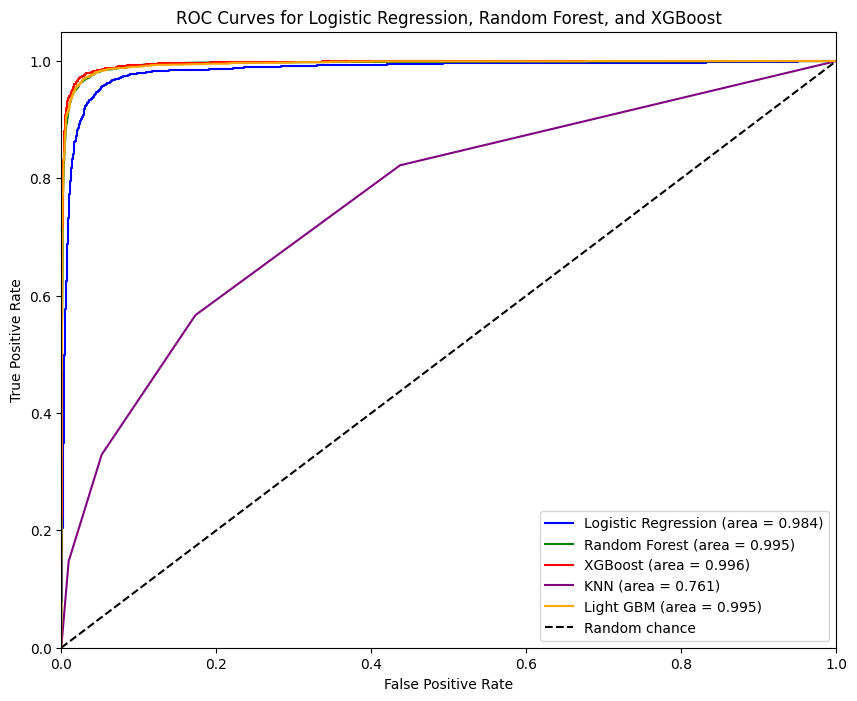

AUC for Logistic Regression: 0.984
AUC for Random Forest: 0.995
AUC for XGBoost: 0.996
AUC for KNN: 0.761
AUC for Light GBM: 0.995


In [184]:
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Define models
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'KNN': knn_model,
    'Light GBM': lgb_model
}

colors = {
    'Logistic Regression': 'blue',
    'Random Forest': 'green',
    'XGBoost': 'red',
    'KNN': 'purple',
    'Light GBM': 'orange'
}

# Dictionary to hold ROC data
roc_data = {}

X = df[['word_overlap', 'bigram_overlap', 'refuting_words_count', 'glove_cosine_similarity', 'headline_len', 'body_len', 'len_ratio', 'headline_polarity', 'headline_subjectivity', 'body_polarity', 'body_subjectivity', 'polarity_diff', 'subjectivity_diff']]
y = df['Stance']

# Create a binary version: Related (agree/disagree/discuss) = 1, Unrelated = 0
y_binary = (df['Stance'] != 'unrelated').astype(int)

# Train-test split again for binary classification
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:,1]  # Probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.3f})', color=colors[name])

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression, Random Forest, and XGBoost')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores
for name, (_, _, roc_auc) in roc_data.items():
    print(f"AUC for {name}: {roc_auc:.3f}")

